# STA314 Tutorial 02 - Coding Exercise

**Goals:**



*   Use Validation/Cross-Validation to evaluate the performance of different models.
*   Compare the runtime and results for Cross-Validation with 10 folds against LOOCV.
*   Select a subset of predictors using forward selection.



## 0. Install and Import Necessary Packages

In [ ]:
!pip install ISLP
!pip install l0bnb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=8ea4fd13e7fc6d5ec088f367d7e69e77c2b26c371e83b4d7171248fab8762d9b
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-non

In [ ]:
import numpy as np
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, poly, sklearn_sm)
from sklearn.model_selection import train_test_split, cross_validate, KFold
import statsmodels.api as sm

import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise ,
  sklearn_selected ,
  sklearn_selection_path)
from l0bnb import fit_path

## 1. Cross-Validation

For this section of the tutorial we will be following Lab 5.3 from the textbook. We will implement and compare the validation set approach to cross validation using the Auto dataset.

### 1.1 Load the Auto Dataset

We are interested in modelling the fuel efficiency (`mpg`) in terms of the different attributes of the car.



In [ ]:
Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


### 1.2 Implement the Validation Set Approach

The validation set approach involves randomly splitting our data into a training set and a validation set. We fit the model using the training set and investigate its performance on the validation set. The function `train_test_split` that we imported earlier performs exactly this split.

In [ ]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196, # Specifies the Val set size
                                          random_state=0) # Random seed for our split

We can fit a simple linear regression model to our training set using only the `horsepower` predictor.

$$\text{mpg} = \beta_0 + \beta_1\text{horsepower} + \epsilon$$


In [ ]:
# Construct design matrix
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']

#Fit OLS model
model = sm.OLS(y_train, X_train)
results = model.fit()

We can then compute the mean squared error on the validation set using the `predict` method on our validation set.

In [ ]:
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid-valid_pred)**2) # Validation set MSE

np.float64(23.61661706966988)

We would like to be able to quickly compare the validation performance of models with different predictors, so we'll construct a function that helps expedite the process.

The function `evalMSE` takes as input:


*   `terms`: Names of the predictors.
*   `response`: Name of the response variable.
*   `train`: Training set.
*   `test`: Validation set.



In [ ]:
def evalMSE(terms, response, train, test):
  mm = MS(terms)
  X_train = mm.fit_transform(train)
  y_train = train[response]
  X_test = mm.transform(test)
  y_test = test[response]

  results = sm.OLS(y_train, X_train).fit()
  test_pred = results.predict(X_test)

  return np.mean((y_test - test_pred)**2)

We can use this function to compare our simple linear regression model to more complex polynomial regression models of the form:

$$
\begin{align*}
\text{mpg} &= \beta_0 + \beta_1\text{hp} + \epsilon\\
\text{mpg} &= \beta_0 + \beta_1\text{hp} + \beta_2\text{hp}^2 + \epsilon\\
\text{mpg} &= \beta_0 + \beta_1\text{hp} + \beta_2\text{hp}^2 + \beta_3\text{hp}^3  + \epsilon\\
\end{align*}
$$

Adding the extra polynomial terms should always lead to a decrease in the training MSE but not necessarily an improvement in testing MSE.

In [ ]:
MSE = np.zeros(3)

for idx, degree in enumerate(range(1,4)):
  MSE[idx] = evalMSE([poly('horsepower', degree)],
                     'mpg',
                     Auto_train,
                     Auto_valid)
MSE

array([23.61661707, 18.76303135, 18.79694163])

Remember that we are training and evaluating each of these models based on the initial validation split we did. If we change the random seed and repeat our study we observe a slightly different validation MSE.

In [ ]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=3)
MSE = np.zeros(3)

for idx, degree in enumerate(range(1,4)):
  MSE[idx] = evalMSE([poly('horsepower', degree)],
                     'mpg',
                     Auto_train,
                     Auto_valid)
MSE

array([20.75540796, 16.94510676, 16.97437833])

In both cases performance is noticeably improved by the inclusion of the quadratic term but including the cubic term has a negligible impact.

### 1.3 Cross-Validation



Recall that cross-validation consists of splitting the available data into "folds". One fold is held for testing and the rest are used for training. We then change which fold is used for testing and repeat the process.

The sklearn library provides cross-validation functionality with the cross_validate function. The authors of the textbook have a convenient sklearn_sm wrapper function which allows for the seamless use of statsmodels objects as arguments to sklearn functions.

The `cv` argument in `cross_validate` denotes the number of folds. In our first example, we take this to be n
(we perform LOOCV).


In [ ]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

np.float64(24.23151351792922)

Let's compare how the cross validation error changes as we add more polynomial terms to our model.

In [ ]:
#%%timeit # Uncomment this line to measure how fast this cell runs (very slow)
cv_error = np.zeros(5)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)

for i,d in enumerate(range(1,6)):
  X = np.power.outer(H, np.arange(d+1)) # Makes a matrix where the jth column is H^j
  M_CV = cross_validate(M,
                        X,
                        Y,
                        cv=Auto.shape[0])
  cv_error[i] = np.mean(M_CV['test_score'])

cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03320648])

We observe a similar trend to what we saw when using a single validation split earlier. Adding a quadratic term decreases the validation error substantially but each subsequence term we add does not seem to improve performance very much.

Let's try the same thing but using 10-fold cross validation instead of LOOCV.

In [ ]:
#%%timeit # Uncomment this line to measure how fast this cell runs
cv_error = np.zeros(5)
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0)
for i, d in enumerate(range(1,6)):
  X = np.power.outer(H, np.arange(d+1))
  M_CV = cross_validate(M,
                        X,
                        Y,
                        cv=cv)
  cv_error[i] = np.mean(M_CV['test_score'])

cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848403, 19.13720065])

We once again observe that the addition of cubic or higher-degree polynomial terms has a negligible impact on the validation error. Notice that the 10-fold cross validation errors are very close to what we got from LOOCV but it ran much faster. Optionally you can uncomment both lines of each cell and rerun to see exactly how much faster.

## 2. Subset Selection

The second part of this tutorial follows Lab 6.5 from the textbook. We will use subset selection methods to try and identify the key features in the `Hitters` dataset for predicting the salary of a baseball player given their performance in the previous season.

### 2.1 Load the Hitters Dataset

In [ ]:
Hitters = load_data('Hitters')
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


Notice that the `Salary` variable is missing in the first row. In fact it turns out that there are 58 other rows with a missing value for the `Salary`. We will drop the rows corresponding the these missing values.

In [ ]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

###2.2 Forward Selection with $C_p$

Recall Mallow's $C_p$ statistic:
$$C_p(\hat{f}) = \frac{1}{n} \mathrm{RSS}(\hat{f}) + \frac{2p\hat{\sigma}^2}{n}.$$


Let's write a function to compute this since it is not implemented in the `sklearn` library.

Since the forward selection functionality in `sklearn` tries to maximize whatever score we give it, we will actually be writing a function to compute the negative $C_p$ statistic.

In [ ]:
# Negative Cp statistic
def nCp(sigma2, estimator, X, Y):
  n, p = X.shape
  Yhat = estimator.predict(X)
  RSS = np.sum((Y-Yhat)**2)
  return -(RSS + 2 * p * sigma2) / n

Since we don't have access to the true $\sigma^2$, we will estimate it by fitting the full model and extracting the MSE.

In [ ]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

We can then define a new function for our negative $C_p$ that has `sigma2` always fixed to be our estimate of the error variance.

In [ ]:
neg_Cp = partial(nCp, sigma2)

Next, we specify a search strategy using the object `Stepwise` in the `ISLP.models` package. The function `Stepwise.first_peak()` with `direction` set as `'forward'` runs forward selection until we are unable to add a variable that improves the score.

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

With both our scoring function and our selection strategy specified, we can use the `sklearn`'s model selection function.

In [ ]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### 2.3 Forward Selection with Cross-Validation

We can combine cross-validation forward seleciton. Instead of using a score like $C_p$, we can use the MSE. The issue is that the training MSE will always decrease as we add more features, so we would also like to perform cross-validation to estimate the expected MSE. This will give us a better idea of whether or not the additional variables are improving our model.

In [ ]:
# Generating the path
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [ ]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

We can plot the training MSE along this path. This is guaranteed to improve as we add more variables. This can be misleading, which is why we need to use cross-validation.

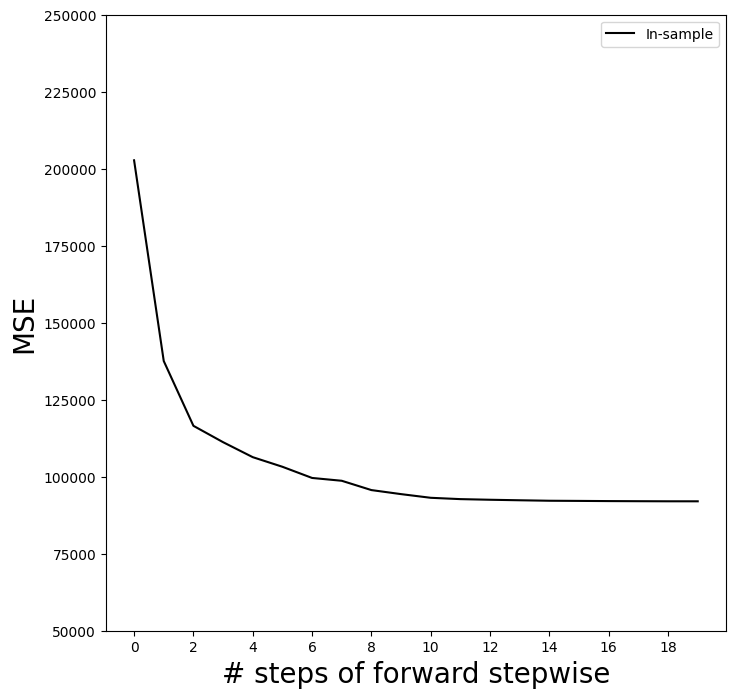

In [ ]:
# We add a dimension (axis) to Y since Yhat_in is two-dimensional
mse_fig , ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse ,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim ([50000 ,250000]);

The next two cells perform cross-validation for each model along the path.

In [ ]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

In [ ]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
  errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
  cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

We obtain a cross-validation MSE for each of the five folds. We will now "cheat" a bit and take the average MSE across these five folds. This yields a crude estimate of the expected MSE since the training sets on each of the folds overlap.

We can then plot how our estimate of the expected MSE evolves as we add more variables. Note that unlike the in-sample MSE, it does not monotonically decrease.

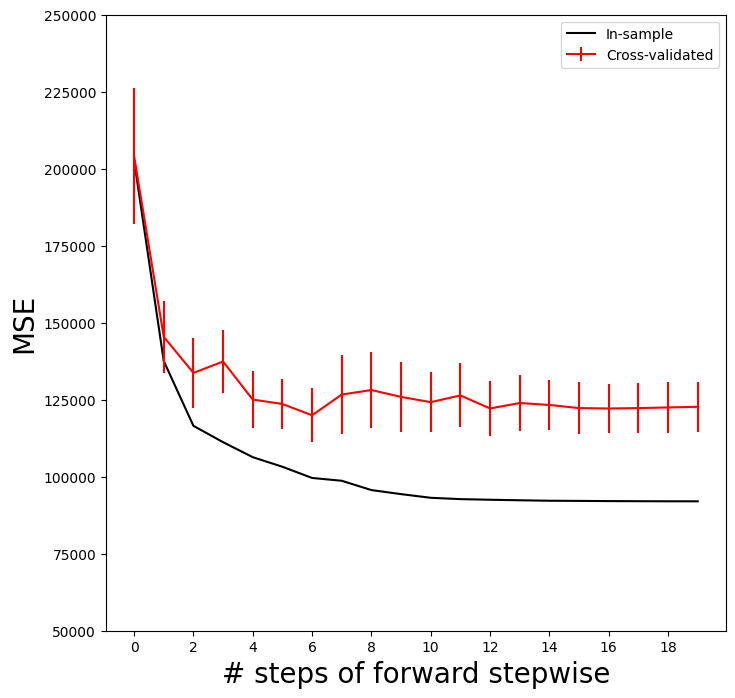

In [ ]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r')
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

## 3. Exercises

**~10 minutes but can be cut short if there is no time**

Working in pairs. Try to complete atleast one of the followwing questions.

### A.

**You will be using LOOCV to evaluate the performance of various models on the following synthetic dataset**

In [ ]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 3*x**2 + x**3 + rng.normal(size=100)

A.1) **Consider the following four models**


1.   $Y = \beta_0 + \beta_1 X + \epsilon$
2.   $Y = \beta_0 + \beta_1X + \beta_2 X^2 + \epsilon$
3.   $Y = \beta_0 + \beta_1X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$
4.   $Y = \beta_0 + \beta_1X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon$

**What trends to you expect to see if we run LOOCV? Why?**

A.2) **Compare these models using LOOCV. Was your answer to A.1) correct?**

### B.

**In the CV portion of the worksheet we only utilized the `horsepower` variable and ignored all other possible predictors. We will make use of the model selection methods covered in the second half of the tutorial to see if a different combination of predictors may be useful.**

B.1) Run forward selection using $C_p$ on the training set split of the Auto dataset. Recall that you need to estimate sigma2 for the $C_p$ function we defined earlier.

In [ ]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=0)


Y_train = np.asarray(Auto_train["mpg"])
terms = list(Auto_train.columns.drop("mpg"))
design_train = MS(terms).fit(Auto_train)

# Your code here

B.2) Fit a model with the variables you selected in B.1) to the training set and then compute the validation MSE. Do the same for the model with a quadratic horsepower term and compare the performance on the validation set (You may want to use the evalMSE function from earlier).